In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages")

print("Path to dataset files:", path)

Path to dataset files: /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1


In [2]:
import os

# Path to the dataset
dataset_path = "/home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1"
expected_languages = ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam', 'Marathi', 'Odia', 'Punjabi', 'Tamil', 'Telugu']

print("📁 Checking contents of downloaded dataset...\n")

if os.path.exists(dataset_path):
    found_languages = []
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}📂 {os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        
        if level == 1 and files:
            print(f"{subindent}🎵 {len(files)} files")
            found_languages.append(os.path.basename(root))
        elif files:
            print(f"{subindent}🎵 {len(files)} files")

else:
    print(f"❌ Dataset path does not exist: {dataset_path}")


📁 Checking contents of downloaded dataset...

📂 1/
  📂 Language Detection Dataset/
    📂 Kannada/
      🎵 22208 files
    📂 Marathi/
      🎵 25379 files
    📂 Punjabi/
      🎵 26229 files
    📂 Telugu/
      🎵 23656 files
    📂 Gujarati/
      🎵 26441 files
    📂 Malayalam/
      🎵 24044 files
    📂 Urdu/
      🎵 31960 files
    📂 Tamil/
      🎵 24196 files
    📂 Hindi/
      🎵 25462 files
    📂 Bengali/
      🎵 27258 files


In [3]:
import os
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ CUDA not available. Using CPU. Training may be slow.")

print(f"Device selected: {device}")


🚀 Using GPU: NVIDIA RTX A5000
Device selected: cuda


In [4]:
import os
import librosa
import numpy as np
from tqdm import tqdm
import joblib

# ----------------------------
# Audio Preprocessing Settings
# ----------------------------
TARGET_SR = 16000                 # Target sampling rate (Hz)
MAX_DURATION = 3.0                # Max clip duration in seconds
MAX_SAMPLES = int(TARGET_SR * MAX_DURATION)  # Max samples per audio

# ----------------------------
# Log-Mel Feature Extraction
# ----------------------------
N_MELS = 128                      # Number of mel bands
N_FFT = 1024                      # Frame size for FFT (~64ms at 16kHz)
HOP_LENGTH = 512                  # Hop size (~32ms at 16kHz)

# ----------------------------
# Data Augmentation Settings
# ----------------------------
AUGMENTATION_PITCH_STEPS = [-2, 0, 2]  # Pitch shifting (in semitones)

# (Optional) Set seed for reproducibility if needed
# np.random.seed(42)


In [5]:
def pad_or_truncate(y, target_len=MAX_SAMPLES):
    """
    Pads or truncates the waveform to a fixed number of samples.
    """
    return y[:target_len] if len(y) > target_len else np.pad(y, (0, target_len - len(y)), mode='constant')


def extract_log_mel_features(y, sr=TARGET_SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Extracts and normalizes log-mel spectrogram features from an audio signal.
    Returns a 2D array of shape (n_mels, time_steps).
    """
    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
    )

    # Convert to log scale (decibels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Per-sample normalization (zero mean, unit variance)
    mean = np.mean(log_mel_spec)
    std = np.std(log_mel_spec)
    if std > 0:
        log_mel_spec = (log_mel_spec - mean) / std
    else:
        log_mel_spec = log_mel_spec - mean  # avoid divide-by-zero

    # Defensive check
    assert np.all(np.isfinite(log_mel_spec)), "Non-finite values found in normalized log-mel spectrogram."

    return log_mel_spec  # Shape: (n_mels, T)



In [6]:
from pydub import AudioSegment

def safe_load_audio(file_path, target_sr=TARGET_SR):
    """
    Safely loads audio from various formats. Uses librosa for .wav/.flac and pydub for .mp3
    Returns waveform (y) and sample rate (sr)
    """
    ext = os.path.splitext(file_path)[1].lower()

    try:
        if ext in ['.wav', '.flac']:
            y, sr = librosa.load(file_path, sr=None, mono=True)
            return y, sr

        elif ext == '.mp3':
            audio = AudioSegment.from_file(file_path, format="mp3")
            audio = audio.set_channels(1).set_frame_rate(target_sr)
            samples = np.array(audio.get_array_of_samples()).astype(np.float32)
            samples /= np.iinfo(audio.array_type).max  # normalize to [-1, 1]
            return samples, target_sr

        else:
            raise ValueError(f"Unsupported file extension: {ext}")
    
    except Exception as e:
        raise RuntimeError(f"Error loading {file_path}: {e}")


In [7]:
def preprocess_and_extract(input_path, output_path, target_sr=TARGET_SR):
    os.makedirs(output_path, exist_ok=True)
    audio_files = [f for f in os.listdir(input_path) if f.endswith(('.wav', '.mp3', '.flac'))]

    processed_count = 0
    error_count = 0

    for file in tqdm(audio_files, desc=f"Processing {os.path.basename(input_path)}"):
        input_file = os.path.join(input_path, file)

        try:
            # 🔁 Replaced with safe loading logic
            try:
                y, sr = safe_load_audio(input_file, target_sr=target_sr)
            except Exception as e:
                print(f"❌ Could not load {file}: {e}")
                error_count += 1
                continue

            y = pad_or_truncate(y)

            for pitch_shift in AUGMENTATION_PITCH_STEPS:
                try:
                    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_shift)
                    y_trimmed, _ = librosa.effects.trim(y_shifted, top_db=30)

                    if sr != target_sr:
                        y_trimmed = librosa.resample(y_trimmed, orig_sr=sr, target_sr=target_sr)

                    peak = np.max(np.abs(y_trimmed))
                    y_normalized = y_trimmed * (0.9 / peak) if peak > 0 else y_trimmed

                    y_fixed = pad_or_truncate(y_normalized)

                    features = extract_log_mel_features(y_fixed, sr=target_sr)

                    base_name = os.path.splitext(file)[0]
                    aug_name = f"{base_name}_ps{pitch_shift}.npy"
                    np.save(os.path.join(output_path, aug_name), features)

                    processed_count += 1

                except Exception as e:
                    print(f"❌ Error during augmentation/processing for {file}: {e}")
                    error_count += 1
                    continue

        except Exception as e:
            print(f"❌ Error processing {file}: {e}")
            error_count += 1
            continue

    return processed_count, error_count


📁 Subfolders found in dataset path:
 - Kannada
 - Marathi
 - Punjabi
 - Telugu
 - Gujarati
 - Malayalam
 - Urdu
 - Tamil
 - Hindi
 - Bengali

🗂️ Saved label mapping: {'Bengali': 0, 'Gujarati': 1, 'Hindi': 2, 'Kannada': 3, 'Malayalam': 4, 'Marathi': 5, 'Punjabi': 6, 'Tamil': 7, 'Telugu': 8, 'Urdu': 9}

🔊 Processing language: Bengali


Processing Bengali:   8%|███▊                                             | 2097/27258 [03:01<32:58, 12.72it/s]

❌ Could not load 26936.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/26936.mp3: Decoding failed. ffmpeg returned error code: 234

Output from ffmpeg/avlib:

ffmpeg version 6.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-2)
  configuration: --prefix=/home/teaching/anaconda3 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libf

Processing Bengali:  13%|██████▍                                          | 3561/27258 [05:09<30:46, 12.83it/s]

❌ Could not load 12750.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/12750.mp3: list index out of range


Processing Bengali:  20%|█████████▊                                       | 5450/27258 [08:04<31:18, 11.61it/s]

❌ Could not load 22988.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/22988.mp3: list index out of range


Processing Bengali:  22%|██████████▋                                      | 5923/27258 [08:53<29:58, 11.86it/s]

❌ Could not load 10250.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/10250.mp3: list index out of range


Processing Bengali:  42%|███████████████████▉                            | 11356/27258 [18:20<22:27, 11.80it/s]

❌ Could not load 3494.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/3494.mp3: list index out of range


Processing Bengali:  44%|█████████████████████                           | 11990/27258 [19:29<34:39,  7.34it/s]

❌ Could not load 18188.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/18188.mp3: list index out of range


Processing Bengali:  47%|██████████████████████▎                         | 12697/27258 [21:19<30:34,  7.94it/s]

❌ Could not load 3894.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/3894.mp3: list index out of range


Processing Bengali:  60%|████████████████████████████▋                   | 16301/27258 [30:14<21:04,  8.66it/s]

❌ Could not load 15630.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/15630.mp3: list index out of range


Processing Bengali:  63%|██████████████████████████████                  | 17069/27258 [31:58<16:40, 10.18it/s]

❌ Could not load 25357.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/25357.mp3: list index out of range


Processing Bengali:  63%|██████████████████████████████                  | 17086/27258 [32:00<18:50,  9.00it/s]

❌ Could not load 24166.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/24166.mp3: list index out of range


Processing Bengali:  72%|██████████████████████████████████▌             | 19650/27258 [37:29<12:55,  9.81it/s]

❌ Could not load 16655.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/16655.mp3: list index out of range


Processing Bengali:  77%|████████████████████████████████████▊           | 20931/27258 [40:19<10:19, 10.21it/s]

❌ Could not load 18831.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/18831.mp3: list index out of range


Processing Bengali:  87%|█████████████████████████████████████████▌      | 23599/27258 [46:18<06:51,  8.89it/s]

❌ Could not load 6149.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/6149.mp3: Decoding failed. ffmpeg returned error code: 234

Output from ffmpeg/avlib:

ffmpeg version 6.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-2)
  configuration: --prefix=/home/teaching/anaconda3 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfon

Processing Bengali:  89%|██████████████████████████████████████████▌     | 24140/27258 [47:35<05:41,  9.13it/s]

❌ Could not load 24102.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/24102.mp3: list index out of range


Processing Bengali:  90%|███████████████████████████████████████████▍    | 24660/27258 [48:51<04:54,  8.82it/s]

❌ Could not load 26824.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/26824.mp3: list index out of range


Processing Bengali:  95%|█████████████████████████████████████████████▎  | 25763/27258 [51:29<02:51,  8.72it/s]

❌ Could not load 19203.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/19203.mp3: list index out of range


Processing Bengali:  95%|█████████████████████████████████████████████▌  | 25890/27258 [51:49<02:52,  7.93it/s]

❌ Could not load 7420.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/7420.mp3: list index out of range


Processing Bengali: 100%|████████████████████████████████████████████████| 27258/27258 [55:18<00:00,  8.21it/s]


✅ 81723 files processed, ❌ 17 errors in Bengali

🔊 Processing language: Gujarati


Processing Gujarati:   9%|████▎                                           | 2366/26441 [06:01<47:38,  8.42it/s]

❌ Could not load 22251.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/22251.mp3: list index out of range


Processing Gujarati:  12%|█████▌                                          | 3094/26441 [07:50<44:25,  8.76it/s]

❌ Could not load 23711.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/23711.mp3: list index out of range


Processing Gujarati:  12%|█████▉                                          | 3296/26441 [08:20<46:55,  8.22it/s]

❌ Could not load 17900.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/17900.mp3: list index out of range


Processing Gujarati:  18%|████████▋                                       | 4768/26441 [10:31<26:58, 13.39it/s]

❌ Could not load 28769.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/28769.mp3: list index out of range


Processing Gujarati:  19%|████████▉                                       | 4946/26441 [10:47<28:11, 12.71it/s]

❌ Could not load 10389.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/10389.mp3: list index out of range


Processing Gujarati:  23%|███████████                                     | 6080/26441 [12:23<25:53, 13.11it/s]

❌ Could not load 20430.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/20430.mp3: list index out of range


Processing Gujarati:  31%|██████████████▋                                 | 8101/26441 [15:17<22:59, 13.29it/s]

❌ Could not load 26943.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/26943.mp3: list index out of range


Processing Gujarati:  42%|███████████████████▊                           | 11119/26441 [19:42<20:47, 12.28it/s]

❌ Could not load 6063.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/6063.mp3: list index out of range


Processing Gujarati:  44%|████████████████████▌                          | 11543/26441 [20:21<19:44, 12.58it/s]

❌ Could not load 5821.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/5821.mp3: list index out of range


Processing Gujarati:  54%|█████████████████████████▎                     | 14259/26441 [24:31<16:52, 12.03it/s]

❌ Could not load 29544.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/29544.mp3: list index out of range


Processing Gujarati:  55%|█████████████████████████▊                     | 14537/26441 [24:56<16:04, 12.34it/s]

❌ Could not load 8885.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/8885.mp3: list index out of range


Processing Gujarati:  55%|█████████████████████████▉                     | 14583/26441 [25:00<16:31, 11.96it/s]

❌ Could not load 20483.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/20483.mp3: list index out of range


Processing Gujarati:  56%|██████████████████████████▏                    | 14709/26441 [25:11<15:22, 12.72it/s]

❌ Could not load 24476.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/24476.mp3: list index out of range


Processing Gujarati:  57%|██████████████████████████▊                    | 15075/26441 [25:45<14:39, 12.92it/s]

❌ Could not load 24897.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/24897.mp3: list index out of range


Processing Gujarati:  60%|████████████████████████████▎                  | 15909/26441 [27:00<14:57, 11.74it/s]

❌ Could not load 28953.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/28953.mp3: list index out of range


Processing Gujarati:  60%|████████████████████████████▍                  | 15989/26441 [27:07<14:16, 12.20it/s]

❌ Could not load 27455.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/27455.mp3: list index out of range


Processing Gujarati:  63%|█████████████████████████████▋                 | 16717/26441 [28:13<12:59, 12.47it/s]

❌ Could not load 9958.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/9958.mp3: list index out of range


Processing Gujarati:  71%|█████████████████████████████████▍             | 18793/26441 [31:22<10:37, 12.00it/s]

❌ Could not load 12851.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/12851.mp3: list index out of range


Processing Gujarati:  73%|██████████████████████████████████▍            | 19393/26441 [32:17<09:25, 12.46it/s]

❌ Could not load 12245.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/12245.mp3: list index out of range


Processing Gujarati:  79%|█████████████████████████████████████          | 20819/26441 [34:26<07:27, 12.57it/s]

❌ Could not load 5410.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/5410.mp3: list index out of range


Processing Gujarati:  90%|██████████████████████████████████████████▏    | 23733/26441 [38:48<03:39, 12.36it/s]

❌ Could not load 13488.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/13488.mp3: list index out of range


Processing Gujarati:  91%|██████████████████████████████████████████▉    | 24185/26441 [39:28<03:05, 12.15it/s]

❌ Could not load 19089.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/19089.mp3: list index out of range


Processing Gujarati:  93%|███████████████████████████████████████████▊   | 24643/26441 [40:09<02:20, 12.76it/s]

❌ Could not load 16409.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/16409.mp3: list index out of range


Processing Gujarati:  94%|████████████████████████████████████████████   | 24777/26441 [40:21<02:14, 12.34it/s]

❌ Could not load 6368.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/6368.mp3: list index out of range


Processing Gujarati:  96%|████████████████████████████████████████████▉  | 25263/26441 [41:04<01:34, 12.51it/s]

❌ Could not load 17487.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Gujarati/17487.mp3: list index out of range


Processing Gujarati: 100%|███████████████████████████████████████████████| 26441/26441 [42:50<00:00, 10.29it/s]


✅ 79248 files processed, ❌ 25 errors in Gujarati

🔊 Processing language: Hindi


Processing Hindi:  29%|███████████████                                    | 7509/25462 [11:20<24:15, 12.34it/s]

❌ Could not load 8139.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/8139.mp3: list index out of range


Processing Hindi:  40%|████████████████████                              | 10217/25462 [15:20<20:15, 12.54it/s]

❌ Could not load 6521.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/6521.mp3: list index out of range


Processing Hindi:  48%|███████████████████████▉                          | 12183/25462 [18:15<18:05, 12.23it/s]

❌ Could not load 23809.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/23809.mp3: list index out of range


Processing Hindi:  58%|████████████████████████████▊                     | 14698/25462 [21:57<13:56, 12.86it/s]

❌ Could not load 13824.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/13824.mp3: list index out of range


Processing Hindi:  62%|██████████████████████████████▊                   | 15666/25462 [23:22<13:17, 12.29it/s]

❌ Could not load 18746.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/18746.mp3: list index out of range


Processing Hindi:  74%|█████████████████████████████████████▏            | 18946/25462 [28:12<08:36, 12.63it/s]

❌ Could not load 25295.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/25295.mp3: list index out of range


Processing Hindi:  77%|██████████████████████████████████████▋           | 19706/25462 [29:18<07:49, 12.25it/s]

❌ Could not load 6346.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/6346.mp3: list index out of range


Processing Hindi:  79%|███████████████████████████████████████▎          | 20006/25462 [29:45<07:15, 12.53it/s]

❌ Could not load 1665.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/1665.mp3: list index out of range


Processing Hindi:  89%|████████████████████████████████████████████▌     | 22724/25462 [33:43<03:45, 12.14it/s]

❌ Could not load 18257.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/18257.mp3: list index out of range


Processing Hindi:  90%|████████████████████████████████████████████▉     | 22890/25462 [33:57<03:32, 12.09it/s]

❌ Could not load 18673.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/18673.mp3: list index out of range


Processing Hindi:  94%|██████████████████████████████████████████████▊   | 23808/25462 [35:18<02:12, 12.45it/s]

❌ Could not load 20261.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Hindi/20261.mp3: list index out of range


Processing Hindi: 100%|██████████████████████████████████████████████████| 25462/25462 [37:43<00:00, 11.25it/s]


✅ 76353 files processed, ❌ 11 errors in Hindi

🔊 Processing language: Kannada


Processing Kannada: 100%|████████████████████████████████████████████████| 22208/22208 [32:50<00:00, 11.27it/s]


✅ 66624 files processed, ❌ 0 errors in Kannada

🔊 Processing language: Malayalam


Processing Malayalam:   2%|▊                                               | 424/24044 [00:38<33:32, 11.74it/s]

❌ Could not load 23081.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Malayalam/23081.mp3: list index out of range


Processing Malayalam:  22%|██████████▍                                    | 5332/24044 [08:02<25:15, 12.35it/s]

❌ Could not load 25125.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Malayalam/25125.mp3: list index out of range


Processing Malayalam:  75%|██████████████████████████████████▎           | 17936/24044 [27:02<08:48, 11.55it/s]

❌ Could not load 24063.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Malayalam/24063.mp3: Decoding failed. ffmpeg returned error code: 69

Output from ffmpeg/avlib:

ffmpeg version 6.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-2)
  configuration: --prefix=/home/teaching/anaconda3 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-lib

Processing Malayalam:  97%|████████████████████████████████████████████▍ | 23216/24044 [35:03<01:07, 12.33it/s]

❌ Could not load 1741.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Malayalam/1741.mp3: list index out of range


Processing Malayalam: 100%|██████████████████████████████████████████████| 24044/24044 [36:19<00:00, 11.03it/s]


✅ 72120 files processed, ❌ 4 errors in Malayalam

🔊 Processing language: Marathi


Processing Marathi:   2%|▊                                                 | 414/25379 [00:38<34:59, 11.89it/s]

❌ Could not load 1800.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/1800.mp3: list index out of range


Processing Marathi:   7%|███▍                                             | 1812/25379 [02:44<29:48, 13.17it/s]

❌ Could not load 19862.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/19862.mp3: list index out of range


Processing Marathi:   9%|████▏                                            | 2174/25379 [03:17<29:51, 12.95it/s]

❌ Could not load 5319.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/5319.mp3: list index out of range


Processing Marathi:  16%|███████▋                                         | 3988/25379 [06:01<29:06, 12.25it/s]

❌ Could not load 22609.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/22609.mp3: list index out of range


Processing Marathi:  16%|███████▉                                         | 4096/25379 [06:11<27:57, 12.69it/s]

❌ Could not load 3432.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/3432.mp3: list index out of range


Processing Marathi:  20%|█████████▉                                       | 5168/25379 [07:47<26:51, 12.54it/s]

❌ Could not load 492.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/492.mp3: list index out of range


Processing Marathi:  28%|█████████████▊                                   | 7176/25379 [10:47<23:40, 12.82it/s]

❌ Could not load 20738.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/20738.mp3: list index out of range


Processing Marathi:  35%|█████████████████▏                               | 8924/25379 [13:26<21:52, 12.54it/s]

❌ Could not load 16626.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/16626.mp3: list index out of range


Processing Marathi:  37%|██████████████████▏                              | 9410/25379 [14:10<21:30, 12.37it/s]

❌ Could not load 13993.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/13993.mp3: list index out of range


Processing Marathi:  41%|███████████████████▊                            | 10456/25379 [15:44<20:23, 12.19it/s]

❌ Could not load 19342.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/19342.mp3: list index out of range


Processing Marathi:  42%|████████████████████▏                           | 10646/25379 [16:01<19:24, 12.65it/s]

❌ Could not load 10608.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/10608.mp3: list index out of range


Processing Marathi:  47%|██████████████████████▍                         | 11860/25379 [17:49<18:02, 12.49it/s]

❌ Could not load 21294.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/21294.mp3: list index out of range


Processing Marathi:  47%|██████████████████████▋                         | 12012/25379 [18:03<17:30, 12.72it/s]

❌ Could not load 297.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/297.mp3: list index out of range


Processing Marathi:  49%|███████████████████████▋                        | 12516/25379 [18:49<17:51, 12.00it/s]

❌ Could not load 585.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/585.mp3: list index out of range


Processing Marathi:  80%|██████████████████████████████████████▌         | 20404/25379 [30:38<06:40, 12.43it/s]

❌ Could not load 16175.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/16175.mp3: list index out of range


Processing Marathi:  90%|███████████████████████████████████████████▍    | 22946/25379 [34:26<03:04, 13.17it/s]

❌ Could not load 20897.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi/20897.mp3: list index out of range


Processing Marathi: 100%|████████████████████████████████████████████████| 25379/25379 [38:02<00:00, 11.12it/s]


✅ 76089 files processed, ❌ 16 errors in Marathi

🔊 Processing language: Punjabi


Processing Punjabi:   7%|███▋                                             | 1946/26229 [02:53<30:24, 13.31it/s]

❌ Could not load 15226.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/15226.mp3: list index out of range


Processing Punjabi:   8%|███▊                                             | 2019/26229 [02:59<31:20, 12.88it/s]

❌ Could not load 9453.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/9453.mp3: list index out of range


Processing Punjabi:  11%|█████▎                                           | 2817/26229 [04:10<31:32, 12.37it/s]

❌ Could not load 15529.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/15529.mp3: list index out of range


Processing Punjabi:  21%|██████████▍                                      | 5581/26229 [08:12<27:48, 12.38it/s]

❌ Could not load 4880.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/4880.mp3: list index out of range


Processing Punjabi:  25%|████████████▍                                    | 6663/26229 [09:47<25:15, 12.91it/s]

❌ Could not load 5212.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/5212.mp3: list index out of range


Processing Punjabi:  28%|█████████████▌                                   | 7249/26229 [10:40<26:48, 11.80it/s]

❌ Could not load 18339.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/18339.mp3: list index out of range


Processing Punjabi:  37%|██████████████████                               | 9664/26229 [14:13<21:15, 12.99it/s]

❌ Could not load 20573.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/20573.mp3: list index out of range


Processing Punjabi:  40%|███████████████████▎                            | 10530/26229 [15:30<19:37, 13.34it/s]

❌ Could not load 3368.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/3368.mp3: list index out of range


Processing Punjabi:  42%|████████████████████▏                           | 11016/26229 [16:12<20:06, 12.61it/s]

❌ Could not load 20020.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/20020.mp3: list index out of range


Processing Punjabi:  44%|█████████████████████▎                          | 11630/26229 [17:05<18:51, 12.91it/s]

❌ Could not load 24798.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/24798.mp3: list index out of range


Processing Punjabi:  45%|█████████████████████▍                          | 11748/26229 [17:15<20:17, 11.90it/s]

❌ Could not load 1927.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/1927.mp3: list index out of range


Processing Punjabi:  49%|███████████████████████▍                        | 12812/26229 [18:48<18:37, 12.00it/s]

❌ Could not load 3055.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/3055.mp3: list index out of range


Processing Punjabi:  53%|█████████████████████████▍                      | 13928/26229 [20:27<15:53, 12.90it/s]

❌ Could not load 15470.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/15470.mp3: list index out of range


Processing Punjabi:  56%|██████████████████████████▉                     | 14744/26229 [21:38<14:29, 13.21it/s]

❌ Could not load 14795.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/14795.mp3: list index out of range


Processing Punjabi:  57%|███████████████████████████▎                    | 14904/26229 [21:52<15:28, 12.19it/s]

❌ Could not load 26080.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/26080.mp3: list index out of range


Processing Punjabi:  65%|███████████████████████████████▏                | 17050/26229 [25:02<12:29, 12.24it/s]

❌ Could not load 10400.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/10400.mp3: list index out of range


Processing Punjabi:  67%|████████████████████████████████▏               | 17570/26229 [25:48<10:53, 13.25it/s]

❌ Could not load 6919.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/6919.mp3: list index out of range


Processing Punjabi:  71%|█████████████████████████████████▉              | 18573/26229 [27:16<10:05, 12.65it/s]

❌ Could not load 25937.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/25937.mp3: list index out of range


Processing Punjabi:  73%|███████████████████████████████████             | 19129/26229 [28:05<09:25, 12.56it/s]

❌ Could not load 13427.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/13427.mp3: list index out of range


Processing Punjabi:  75%|████████████████████████████████████▏           | 19749/26229 [29:00<07:45, 13.91it/s]

❌ Could not load 20169.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/20169.mp3: list index out of range
❌ Could not load 13085.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/13085.mp3: list index out of range


Processing Punjabi:  83%|███████████████████████████████████████▋        | 21673/26229 [31:51<05:46, 13.15it/s]

❌ Could not load 14045.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/14045.mp3: list index out of range


Processing Punjabi:  87%|█████████████████████████████████████████▋      | 22799/26229 [33:29<04:39, 12.26it/s]

❌ Could not load 16434.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/16434.mp3: list index out of range


Processing Punjabi:  93%|████████████████████████████████████████████▌   | 24354/26229 [35:45<02:28, 12.63it/s]

❌ Could not load 20111.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/20111.mp3: list index out of range


Processing Punjabi:  95%|█████████████████████████████████████████████▍  | 24856/26229 [36:30<01:49, 12.49it/s]

❌ Could not load 17550.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Punjabi/17550.mp3: list index out of range


Processing Punjabi: 100%|████████████████████████████████████████████████| 26229/26229 [38:31<00:00, 11.35it/s]


✅ 78612 files processed, ❌ 25 errors in Punjabi

🔊 Processing language: Tamil


Processing Tamil:   1%|▋                                                   | 344/24196 [00:30<32:23, 12.27it/s]

❌ Could not load 9008.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/9008.mp3: list index out of range


Processing Tamil:   5%|██▋                                                | 1250/24196 [01:49<29:19, 13.04it/s]

❌ Could not load 20861.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/20861.mp3: list index out of range


Processing Tamil:   5%|██▋                                                | 1288/24196 [01:52<30:12, 12.64it/s]

❌ Could not load 25491.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/25491.mp3: list index out of range


Processing Tamil:   6%|██▉                                                | 1416/24196 [02:03<28:54, 13.13it/s]

❌ Could not load 4713.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/4713.mp3: list index out of range


Processing Tamil:  10%|█████                                              | 2398/24196 [03:31<28:53, 12.57it/s]

❌ Could not load 17114.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/17114.mp3: list index out of range


Processing Tamil:  13%|██████▌                                            | 3104/24196 [04:33<27:27, 12.80it/s]

❌ Could not load 15195.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/15195.mp3: list index out of range


Processing Tamil:  26%|█████████████▏                                     | 6266/24196 [09:08<22:29, 13.29it/s]

❌ Could not load 21812.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/21812.mp3: list index out of range


Processing Tamil:  27%|█████████████▉                                     | 6628/24196 [09:39<22:58, 12.75it/s]

❌ Could not load 23387.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/23387.mp3: list index out of range


Processing Tamil:  31%|███████████████▌                                   | 7385/24196 [10:43<21:03, 13.30it/s]

❌ Could not load 22138.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/22138.mp3: list index out of range


Processing Tamil:  40%|████████████████████▏                              | 9605/24196 [13:53<18:22, 13.23it/s]

❌ Could not load 19386.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/19386.mp3: list index out of range


Processing Tamil:  40%|████████████████████▌                              | 9755/24196 [14:06<18:27, 13.04it/s]

❌ Could not load 20076.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/20076.mp3: list index out of range


Processing Tamil:  41%|█████████████████████                              | 9983/24196 [14:25<19:02, 12.44it/s]

❌ Could not load 23613.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/23613.mp3: Decoding failed. ffmpeg returned error code: 234

Output from ffmpeg/avlib:

ffmpeg version 6.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-2)
  configuration: --prefix=/home/teaching/anaconda3 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1699729448698/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfon

Processing Tamil:  41%|████████████████████▋                             | 10004/24196 [14:27<18:13, 12.98it/s]

❌ Could not load 7659.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/7659.mp3: list index out of range


Processing Tamil:  44%|█████████████████████▊                            | 10534/24196 [15:12<17:47, 12.80it/s]

❌ Could not load 12363.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/12363.mp3: list index out of range


Processing Tamil:  60%|██████████████████████████████▏                   | 14633/24196 [21:02<12:05, 13.17it/s]

❌ Could not load 10189.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/10189.mp3: list index out of range


Processing Tamil:  61%|██████████████████████████████▍                   | 14728/24196 [21:10<12:08, 13.00it/s]

❌ Could not load 11141.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/11141.mp3: list index out of range


Processing Tamil:  62%|██████████████████████████████▊                   | 14923/24196 [21:27<11:41, 13.22it/s]

❌ Could not load 14661.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/14661.mp3: list index out of range


Processing Tamil:  62%|███████████████████████████████▏                  | 15087/24196 [21:41<11:40, 13.00it/s]

❌ Could not load 7641.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/7641.mp3: list index out of range


Processing Tamil:  66%|█████████████████████████████████                 | 16008/24196 [22:59<10:23, 13.12it/s]

❌ Could not load 26775.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/26775.mp3: list index out of range


Processing Tamil:  78%|██████████████████████████████████████▊           | 18758/24196 [26:54<06:47, 13.35it/s]

❌ Could not load 14663.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/14663.mp3: list index out of range


Processing Tamil:  80%|████████████████████████████████████████▏         | 19467/24196 [27:54<06:04, 12.98it/s]

❌ Could not load 5290.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/5290.mp3: list index out of range


Processing Tamil:  84%|██████████████████████████████████████████▏       | 20443/24196 [29:17<04:36, 13.56it/s]

❌ Could not load 6550.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/6550.mp3: list index out of range


Processing Tamil:  85%|██████████████████████████████████████████▋       | 20684/24196 [29:38<04:27, 13.15it/s]

❌ Could not load 17279.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/17279.mp3: list index out of range


Processing Tamil:  90%|████████████████████████████████████████████▉     | 21759/24196 [31:09<03:04, 13.19it/s]

❌ Could not load 24384.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/24384.mp3: list index out of range


Processing Tamil:  95%|███████████████████████████████████████████████▋  | 23105/24196 [33:04<01:25, 12.74it/s]

❌ Could not load 9509.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/9509.mp3: list index out of range


Processing Tamil:  98%|█████████████████████████████████████████████████ | 23720/24196 [33:57<00:36, 13.16it/s]

❌ Could not load 13679.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/13679.mp3: list index out of range


Processing Tamil: 100%|█████████████████████████████████████████████████▊| 24110/24196 [34:30<00:06, 13.66it/s]

❌ Could not load 9161.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Tamil/9161.mp3: list index out of range


Processing Tamil: 100%|██████████████████████████████████████████████████| 24196/24196 [34:37<00:00, 11.65it/s]


✅ 72507 files processed, ❌ 27 errors in Tamil

🔊 Processing language: Telugu


Processing Telugu:   7%|███▋                                              | 1742/23656 [02:29<27:30, 13.28it/s]

❌ Could not load 9730.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/9730.mp3: list index out of range


Processing Telugu:   7%|███▋                                              | 1754/23656 [02:30<28:21, 12.87it/s]

❌ Could not load 24991.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/24991.mp3: list index out of range


Processing Telugu:  15%|███████▍                                          | 3535/23656 [05:03<25:09, 13.33it/s]

❌ Could not load 8270.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/8270.mp3: list index out of range


Processing Telugu:  21%|██████████▌                                       | 5013/23656 [07:10<23:25, 13.26it/s]

❌ Could not load 19623.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/19623.mp3: list index out of range


Processing Telugu:  26%|████████████▉                                     | 6099/23656 [08:43<21:52, 13.37it/s]

❌ Could not load 11099.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/11099.mp3: list index out of range


Processing Telugu:  27%|█████████████▍                                    | 6333/23656 [09:02<21:38, 13.34it/s]

❌ Could not load 5309.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/5309.mp3: list index out of range


Processing Telugu:  27%|█████████████▍                                    | 6346/23656 [09:04<21:38, 13.33it/s]

❌ Could not load 18173.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/18173.mp3: list index out of range


Processing Telugu:  36%|██████████████████                                | 8525/23656 [12:11<19:15, 13.09it/s]

❌ Could not load 9076.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/9076.mp3: list index out of range


Processing Telugu:  39%|███████████████████▋                              | 9340/23656 [13:21<18:02, 13.23it/s]

❌ Could not load 12983.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/12983.mp3: list index out of range


Processing Telugu:  61%|██████████████████████████████▏                  | 14548/23656 [20:52<12:04, 12.58it/s]

❌ Could not load 8982.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/8982.mp3: list index out of range


Processing Telugu:  69%|██████████████████████████████████               | 16418/23656 [23:33<09:06, 13.25it/s]

❌ Could not load 19188.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/19188.mp3: list index out of range


Processing Telugu:  95%|██████████████████████████████████████████████▋  | 22511/23656 [32:16<01:28, 12.92it/s]

❌ Could not load 20330.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Telugu/20330.mp3: list index out of range


Processing Telugu: 100%|█████████████████████████████████████████████████| 23656/23656 [33:54<00:00, 11.63it/s]


✅ 70932 files processed, ❌ 12 errors in Telugu

🔊 Processing language: Urdu


Processing Urdu:   4%|██▎                                                 | 1426/31960 [02:02<39:40, 12.83it/s]

❌ Could not load 26477.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/26477.mp3: list index out of range


Processing Urdu:  13%|██████▌                                             | 4019/31960 [05:44<35:11, 13.23it/s]

❌ Could not load 20396.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/20396.mp3: list index out of range


Processing Urdu:  13%|██████▊                                             | 4210/31960 [06:00<35:16, 13.11it/s]

❌ Could not load 5633.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/5633.mp3: list index out of range


Processing Urdu:  15%|███████▌                                            | 4641/31960 [06:37<34:42, 13.12it/s]

❌ Could not load 8349.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/8349.mp3: list index out of range


Processing Urdu:  21%|██████████▊                                         | 6670/31960 [09:31<32:08, 13.12it/s]

❌ Could not load 11404.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/11404.mp3: list index out of range


Processing Urdu:  24%|████████████▌                                       | 7734/31960 [11:02<31:40, 12.75it/s]

❌ Could not load 14159.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/14159.mp3: list index out of range


Processing Urdu:  25%|████████████▊                                       | 7911/31960 [11:17<29:53, 13.41it/s]

❌ Could not load 1044.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/1044.mp3: list index out of range


Processing Urdu:  31%|███████████████▉                                    | 9787/31960 [13:57<29:12, 12.65it/s]

❌ Could not load 9374.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/9374.mp3: list index out of range


Processing Urdu:  34%|█████████████████▍                                 | 10944/31960 [15:36<26:27, 13.24it/s]

❌ Could not load 15428.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/15428.mp3: list index out of range


Processing Urdu:  35%|█████████████████▋                                 | 11045/31960 [15:45<26:45, 13.03it/s]

❌ Could not load 16534.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/16534.mp3: list index out of range


Processing Urdu:  35%|█████████████████▉                                 | 11256/31960 [16:03<26:18, 13.12it/s]

❌ Could not load 21751.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/21751.mp3: list index out of range


Processing Urdu:  40%|████████████████████▌                              | 12850/31960 [18:19<25:07, 12.68it/s]

❌ Could not load 15599.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/15599.mp3: list index out of range


Processing Urdu:  47%|███████████████████████▊                           | 14940/31960 [21:17<21:22, 13.27it/s]

❌ Could not load 7169.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/7169.mp3: list index out of range


Processing Urdu:  59%|██████████████████████████████▎                    | 18996/31960 [27:04<16:17, 13.27it/s]

❌ Could not load 20010.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/20010.mp3: list index out of range


Processing Urdu:  66%|█████████████████████████████████▊                 | 21188/31960 [30:11<14:09, 12.67it/s]

❌ Could not load 28360.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/28360.mp3: list index out of range


Processing Urdu:  74%|█████████████████████████████████████▉             | 23799/31960 [33:54<10:24, 13.08it/s]

❌ Could not load 27659.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/27659.mp3: list index out of range


Processing Urdu:  76%|██████████████████████████████████████▉            | 24416/31960 [34:47<09:26, 13.32it/s]

❌ Could not load 16756.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/16756.mp3: list index out of range


Processing Urdu:  97%|█████████████████████████████████████████████████▎ | 30883/31960 [43:59<01:22, 13.11it/s]

❌ Could not load 21737.mp3: Error loading /home/teaching/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Urdu/21737.mp3: list index out of range


Processing Urdu: 100%|███████████████████████████████████████████████████| 31960/31960 [45:31<00:00, 11.70it/s]

✅ 95826 files processed, ❌ 18 errors in Urdu

📊 Final Summary:
✔️ Total Processed Files: 770034
❌ Total Errors: 155


In [8]:
import numpy as np

all_shapes = set()
language_dirs = [
                    'Bengali',
                    'Gujarati',
                    'Hindi',
                    'Kannada',
                    'Malayalam',
                    'Marathi',
                    'Punjabi',
                    'Tamil',
                    'Telugu',
                    'Urdu'
                    ]
output_path = "/home/teaching/features"
for lang in language_dirs:
    folder = os.path.join(output_path, lang)
    for file in os.listdir(folder):
        if file.endswith(".npy"):
            shape = np.load(os.path.join(folder, file)).shape
            all_shapes.add(shape)

if len(all_shapes) == 1:
    print(f"✅ All spectrograms have consistent shape: {list(all_shapes)[0]}")
else:
    print(f"⚠️ Inconsistent spectrogram shapes found: {all_shapes}")


✅ All spectrograms have consistent shape: (128, 94)


Spectrogram shape: (128, 94)


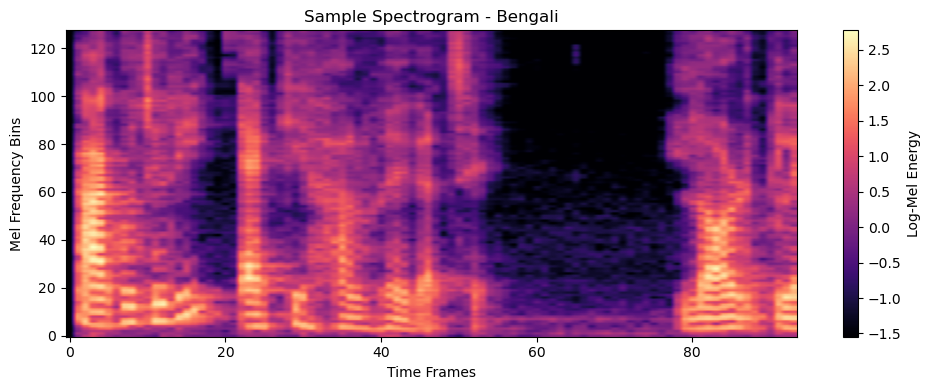

In [9]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Select a sample file
language = language_dirs[0]
sample_file = os.path.join(output_path, language, os.listdir(os.path.join(output_path, language))[0])

# Load spectrogram
spectrogram = np.load(sample_file)
print("Spectrogram shape:", spectrogram.shape)  # Should print (128, 94)

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, origin='lower', aspect='auto', cmap='magma')
plt.title(f"Sample Spectrogram - {language}")
plt.colorbar(label='Log-Mel Energy')
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.tight_layout()
plt.show()


In [10]:
import joblib

language_dirs = [
    'Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam',
    'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu'
]
label_mapping = {lang: idx for idx, lang in enumerate(language_dirs)}

joblib.dump(label_mapping, "/home/teaching/features/label_mapping.pkl")
print("✅ Regenerated label_mapping.pkl")


✅ Regenerated label_mapping.pkl


In [11]:
import os
import joblib
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Paths=
features_dir = "/home/teaching/features"
split_save_path = "/home/teaching/features/splits"
os.makedirs(split_save_path, exist_ok=True)

# Load label mapping
label_mapping = joblib.load(os.path.join(features_dir, 'label_mapping.pkl'))

# Gather all file paths and labels
file_paths = []
labels = []

for lang, label in label_mapping.items():
    lang_dir = os.path.join(features_dir, lang)
    for file in os.listdir(lang_dir):
        if file.endswith('.npy'):
            file_paths.append(os.path.join(lang_dir, file))
            labels.append(label)

print(f"🔢 Total samples found: {len(file_paths)}")

# Stratified 80-10-10 split
X_temp, X_test, y_temp, y_test = train_test_split(
    file_paths, labels, test_size=0.10, stratify=labels, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)
    # 0.1111 of 90% ≈ 10% of total

# Confirm distribution
print(f"✔️ Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

# Save splits
joblib.dump((X_train, y_train), os.path.join(split_save_path, "train.pkl"))
joblib.dump((X_val, y_val), os.path.join(split_save_path, "val.pkl"))
joblib.dump((X_test, y_test), os.path.join(split_save_path, "test.pkl"))

print("✅ Train/Val/Test splits saved successfully.")


🔢 Total samples found: 770037
✔️ Train size: 616037, Val size: 76996, Test size: 77004
✅ Train/Val/Test splits saved successfully.


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int = 144, max_len: int = 10000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, length: int):
        return self.pe[:, :length]


class LayerNorm(nn.Module):
    def __init__(self, d_hid, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_hid))
        self.beta = nn.Parameter(torch.zeros(d_hid))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


class ConformerConvModule(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.pointwise_conv1 = nn.Conv1d(in_channels, 2 * in_channels, kernel_size=1)
        self.glu = nn.GLU(dim=1)
        self.depthwise_conv = nn.Conv1d(in_channels, in_channels, kernel_size=31,
                                        groups=in_channels, padding=15)
        self.batch_norm = nn.BatchNorm1d(in_channels)
        self.swish = nn.SiLU()
        self.pointwise_conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.pointwise_conv1(x)
        x = self.glu(x)
        x = self.depthwise_conv(x)
        x = self.batch_norm(x)
        x = self.swish(x)
        x = self.pointwise_conv2(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)
        return x


class FeedForwardModule(nn.Module):
    def __init__(self, d_model, d_ff=256, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.layernorm = LayerNorm(d_model)

    def forward(self, x):
        residual = x
        x = self.layernorm(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return 0.5 * x + residual


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.layernorm = LayerNorm(d_model)

    def forward(self, x, mask=None):
        residual = x
        x = self.layernorm(x)
        x, _ = self.attention(x, x, x, key_padding_mask=mask)
        x = self.dropout(x)
        return x + residual


class AttentionPooling(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = nn.Linear(d_model, 1)

    def forward(self, x):
        attn_weights = F.softmax(self.attn(x), dim=1)
        return torch.sum(attn_weights * x, dim=1)


class ConformerBlock(nn.Module):
    def __init__(self, d_model, d_ff, num_heads):
        super().__init__()
        self.ff1 = FeedForwardModule(d_model, d_ff)
        self.mhsa = MultiHeadSelfAttention(d_model, num_heads)
        self.conv = ConformerConvModule(d_model)
        self.ff2 = FeedForwardModule(d_model, d_ff)
        self.layernorm = LayerNorm(d_model)

    def forward(self, x, mask=None):
        x = self.ff1(x)
        x = self.mhsa(x, mask)
        x = self.conv(x)
        x = self.ff2(x)
        return self.layernorm(x)


class MFCCConformerModel(nn.Module):
    def __init__(self, input_dim=128, d_model=144, d_ff=256, num_heads=4,
                 num_classes=10, num_blocks=4, dropout=0.1, max_len=1000):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            ConformerBlock(d_model, d_ff, num_heads) for _ in range(num_blocks)
        ])
        self.pool = AttentionPooling(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, mask=None):
        # x: (batch, time, mel)
        x = self.input_proj(x)                                 # (batch, time, d_model)
        pos_encoding = self.pos_enc(x.shape[1]).to(x.device)
        x = x + pos_encoding

        x = self.dropout(x)
        for block in self.blocks:
            x = block(x, mask)                                 # Pass through Conformer blocks
        return self.classifier(self.pool(x))                   # Attention pooling + classifier


In [13]:
import torch
from torch.utils.data import Dataset
import numpy as np
import joblib

class MFCCDataset(Dataset):
    def __init__(self, pkl_file):
        # Load (file_paths, labels) from joblib pickle file
        self.file_paths, self.labels = joblib.load(pkl_file)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load Mel spectrogram
        feature = np.load(self.file_paths[idx])  # Shape: (mel, time)
        feature = feature.T                      # Now (time, mel)
        feature_tensor = torch.tensor(feature, dtype=torch.float32)
    
        # Get label
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        
    
        return feature_tensor, label_tensor



In [14]:
# from your_model_file import MFCCConformerModel  # make sure this file has the latest model definition

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Use input_dim=128 for Mel spectrograms
model = MFCCConformerModel(input_dim=128, num_classes=10).to(device)


In [15]:
from torch.utils.data import DataLoader

# Load dataset splits
train_dataset = MFCCDataset("/home/teaching/features/splits/train.pkl")
val_dataset   = MFCCDataset("/home/teaching/features/splits/val.pkl")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)


In [16]:
import torch.optim as optim
import torch.nn as nn

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler (optional but recommended)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [17]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")


Total Parameters: 1,240,427


In [18]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params:,}")


Trainable Parameters: 1,240,427


In [19]:
from tqdm import tqdm

EPOCHS = 5
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"\n🔁 Epoch {epoch+1}/{EPOCHS}")
    
    model.train()
    running_loss = 0
    train_loader_tqdm = tqdm(train_loader, desc="🧠 Training", leave=False)

    for x_batch, y_batch in train_loader_tqdm:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    val_loader_tqdm = tqdm(val_loader, desc="🔍 Validating", leave=False)

    with torch.no_grad():
        for x_batch, y_batch in val_loader_tqdm:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

            _, preds = torch.max(output, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total * 100

    print(f"📊 Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_conformer_model_mel.pt")
        print("✅ Saved best model.")



🔁 Epoch 1/5


📊 Epoch 1: Train Loss=0.3972, Val Loss=0.2567, Val Acc=87.10%
✅ Saved best model.

🔁 Epoch 2/5


📊 Epoch 2: Train Loss=0.2327, Val Loss=0.1943, Val Acc=88.22%
✅ Saved best model.

🔁 Epoch 3/5


📊 Epoch 3: Train Loss=0.2081, Val Loss=0.1870, Val Acc=88.47%
✅ Saved best model.

🔁 Epoch 4/5


📊 Epoch 4: Train Loss=0.1964, Val Loss=0.1841, Val Acc=88.56%
✅ Saved best model.

🔁 Epoch 5/5


📊 Epoch 5: Train Loss=0.1898, Val Loss=0.1833, Val Acc=88.61%
✅ Saved best model.



📌 Final Evaluation: Loss = 0.1833, Accuracy = 88.61%

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8171
           1       0.50      0.88      0.64      7924
           2       0.97      1.00      0.98      7635
           3       0.98      0.97      0.97      6662
           4       0.99      0.98      0.99      7212
           5       0.98      0.99      0.98      7608
           6       0.51      0.12      0.19      7860
           7       0.99      0.99      0.99      7250
           8       1.00      0.99      0.99      7092
           9       0.98      0.98      0.98      9582

    accuracy                           0.89     76996
   macro avg       0.89      0.89      0.87     76996
weighted avg       0.89      0.89      0.87     76996



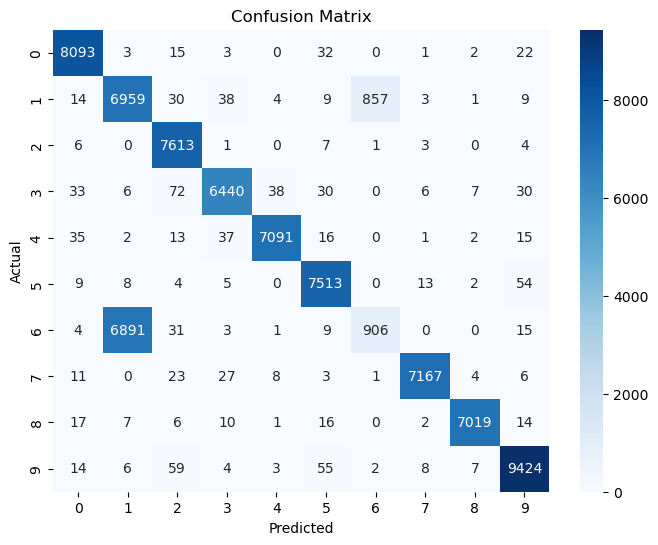

In [29]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Load best model ===
model.load_state_dict(torch.load("best_conformer_model_mel.pt"))
model.to(device)
model.eval()

# === Evaluation loop ===
test_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []

val_loader_tqdm = tqdm(val_loader, desc="📈 Evaluating", leave=False)

with torch.no_grad():
    for x_batch, y_batch in val_loader_tqdm:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)

        test_loss += loss.item()
        _, preds = torch.max(output, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

avg_loss = test_loss / len(val_loader)
accuracy = correct / total * 100

print(f"\n📌 Final Evaluation: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

# === Classification report ===
print("\n🧾 Classification Report:")
print(classification_report(all_labels, all_preds))

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [30]:
# === Extract embeddings before classification ===
embedding_list = []
label_list = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(val_loader, desc="🔍 Extracting Embeddings"):
        x_batch = x_batch.to(device)
        x_proj = model.input_proj(x_batch)
        x_pos = x_proj + model.pos_enc(x_batch.shape[1]).to(device)
        pooled = model.pool(x_pos)
        embedding_list.append(pooled.cpu())
        label_list.extend(y_batch.numpy())

embedding_array = torch.cat(embedding_list).numpy()
label_array = np.array(label_list)


🔍 Extracting Embeddings: 100%|███████████████████████████████████████████| 2407/2407 [00:10<00:00, 223.98it/s]


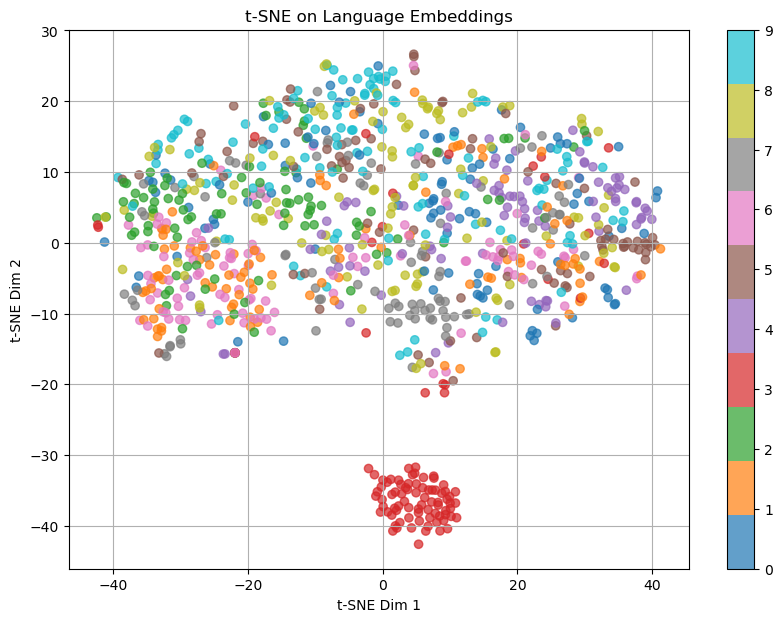

In [31]:
from sklearn.manifold import TSNE

# Sample a subset
np.random.seed(42)
idxs = np.random.choice(len(embedding_array), 1000, replace=False)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embedding_array[idxs])

plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=label_array[idxs], cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("t-SNE on Language Embeddings")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()


In [57]:
import os
import numpy as np
import librosa
from tqdm import tqdm
import torch
import torch.nn.functional as F

AUGMENTATION_PITCH_STEPS = [0]  # You can include [+2, -2] if needed
TARGET_SR = 16000
N_MELS = 128

# Labels (match class index)
class_names = [
    "Bengali", "Gujarati", "Hindi", "Kannada", "Malayalam",
    "Marathi", "Punjabi", "Tamil", "Telugu", "Urdu"
]

def safe_load_audio(path, target_sr=16000):
    y, sr = librosa.load(path, sr=None)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    return y, target_sr

def pad_or_truncate(y, target_len=TARGET_SR * 4):  # 4 seconds
    if len(y) > target_len:
        return y[:target_len]
    else:
        return np.pad(y, (0, target_len - len(y)))

def extract_log_mel_features(y, sr=TARGET_SR):
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=N_MELS, n_fft=512, hop_length=160)
    log_mel = librosa.power_to_db(mel_spec)
    return log_mel.T  # (time, mel)

def preprocess_and_predict(input_path, model, target_sr=TARGET_SR):
    model.eval()
    predictions = []
    true_labels = []

    audio_files = [f for f in os.listdir(input_path) if f.endswith(('.wav', '.mp3', '.flac'))]

    for file in tqdm(audio_files, desc="🔍 Predicting"):
        input_file = os.path.join(input_path, file)

        try:
            y, sr = safe_load_audio(input_file, target_sr=target_sr)
            y = pad_or_truncate(y)

            for pitch_shift in AUGMENTATION_PITCH_STEPS:
                y_aug = librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_shift)
                y_aug = pad_or_truncate(y_aug)

                features = extract_log_mel_features(y_aug, sr)
                features = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(model.device)

                with torch.no_grad():
                    out = model(features)
                    probs = F.softmax(out, dim=1).cpu().numpy().flatten()
                    predicted_idx = probs.argmax()

                    predictions.append(class_names[predicted_idx])
                    # Get true label from filename (assuming file is named: Hindi_123.wav)
                    true_label = file.split("_")[0]
                    true_labels.append(true_label)

        except Exception as e:
            print(f"⚠️ Error processing {file}: {e}")
            continue

    return predictions, true_labels


In [58]:
# Load model
model = MFCCConformerModel(num_classes=len(class_names))
model.load_state_dict(torch.load("best_conformer_model_mel.pt", map_location="cpu"))
model.device = torch.device("cpu")  # add device attribute if not in class
model.to(model.device)

# Run predictions
input_path = "/home/teaching/dl_2/"  # Folder containing test audio files
preds, truths = preprocess_and_predict(input_path, model)



🔍 Predicting: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 29.99it/s]


In [66]:
import gradio as gr
import torch
import torchaudio
import librosa
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

# === Model & Label Setup ===
class_names = [
    "Bengali", "Gujarati", "Hindi", "Kannada", "Malayalam",
    "Marathi", "Punjabi", "Tamil", "Telugu", "Urdu"
]

TARGET_SR = 16000
N_MELS = 128
AUGMENTATION_PITCH_STEPS = [0]  # optional: try [-2, 0, +2] if you want augmentation

# === Audio Processing Functions ===
def safe_load_audio(file_path, target_sr=TARGET_SR):
    y, sr = librosa.load(file_path, sr=None)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    return y, target_sr

def pad_or_truncate(y, target_len=TARGET_SR * 4):
    if len(y) > target_len:
        return y[:target_len]
    return np.pad(y, (0, target_len - len(y)))

def extract_log_mel_features(y, sr):
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=N_MELS, n_fft=512, hop_length=160)
    log_mel = librosa.power_to_db(mel_spec)
    return log_mel.T  # (time, mel)

# === Model Prediction Function ===
def predict_language(file_path):
    y, sr = safe_load_audio(file_path)
    y = pad_or_truncate(y)

    y_aug = librosa.effects.pitch_shift(y, sr=sr, n_steps=0)  # no pitch shift
    features = extract_log_mel_features(y_aug, sr)

    features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(model.device)

    with torch.no_grad():
        output = model(features_tensor)
        probs = F.softmax(output, dim=1).cpu().numpy().flatten()
        predicted_idx = np.argmax(probs)
    
    prediction = class_names[predicted_idx]

    # Bar chart
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(class_names, probs)
    ax.set_ylabel("Probability")
    ax.set_title("Language Prediction Probabilities")
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    plt.tight_layout()

    return prediction, fig

# === Load Model ===
model = MFCCConformerModel(num_classes=len(class_names))
model.load_state_dict(torch.load("best_conformer_model_mel.pt", map_location="cpu"))
model.device = torch.device("cpu")
model.to(model.device)
model.eval()

# === Gradio Interface ===
interface = gr.Interface(
    fn=predict_language,
    inputs=gr.Audio(type="filepath", label="Upload Audio File"),
    outputs=[
        gr.Textbox(label="Predicted Language"),
        gr.Plot(label="Probability Distribution")
    ],
    title="🔤 Indian Language Detection",
    description="Upload an audio clip (up to 4 seconds) and the Conformer model will predict the spoken Indian language.",
    flagging_mode="never"  # updated flagging setting
)

interface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://ce546d35b46106d87d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
